<a href="https://colab.research.google.com/github/GawainGan/Machine-Learning-Engineering-for-Production-Specialization/blob/main/3-Machine%20Learning%20Modeling%20Pipelines%20in%20Production/W2/C3_W2_Lab_3_Quantization_and_Pruning_with_Note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Quantization and Pruning

In this lab, you will get some hands-on practice with the mobile optimization techniques discussed in the lectures. These enable reduced model size and latency which makes it ideal for edge and IOT devices. You will start by training a Keras model then compare its model size and accuracy after going through these techniques:

* post-training quantization
* quantization aware training
* weight pruning

Let's begin!

## Imports

Let's first import a few common libraries that you'll be using throughout the notebook.

In [1]:
import tensorflow as tf
import numpy as np
import os
import tempfile
import zipfile

<a name='utilities'>

## Utilities and constants

Let's first define a few string constants and utility functions to make our code easier to maintain.

In [6]:
# GLOBAL VARIABLES

# String constants for model filenames
FILE_WEIGHTS = 'baseline_weights.h5'
FILE_NON_QUANTIZED_H5 = 'non_quantized.h5'
FILE_NON_QUANTIZED_TFLITE = 'non_quantized.tflite'
FILE_PT_QUANTIZED = 'post_training_quantized.tflite'
FILE_QAT_QUANTIZED = 'quant_aware_quantized.tflite'
FILE_PRUNED_MODEL_H5 = 'pruned_model.h5'
FILE_PRUNED_QUANTIZED_TFLITE = 'pruned_quantized.tflite'
FILE_PRUNED_NON_QUANTIZED_TFLITE = 'pruned_non_quantized.tflite'

# Dictionaries to hold measurements
MODEL_SIZE = {}
ACCURACY = {}

In [2]:
# UTILITY FUNCTIONS

def print_metric(metric_dict, metric_name):
  '''Prints key and values stored in a dictionary'''
  for metric, value in metric_dict.items():
    print(f'{metric_name} for {metric}: {value}')


def model_builder():
  '''Returns a shallow CNN for training on the MNIST dataset'''

  keras = tf.keras

  # Define the model architecture.
  model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  return model


def evaluate_tflite_model(filename, x_test, y_test):
  '''
  评估一个TensorFlow Lite模型在给定测试集上的准确性。
  此函数加载一个TF Lite模型文件，然后使用提供的测试图像和标签来评估模型的准确率。
  该函数详细说明了如何使用TensorFlow Lite解释器运行推理，并且是在部署优化模型时评估性能的有效方法。
  Measures the accuracy of a given TF Lite model and test set

  Args:
    filename (string) - filename of the model to load
    x_test (numpy array) - test images
    y_test (numpy array) - test labels

  Returns
    float showing the accuracy against the test set
  '''

  # Initialize the TF Lite Interpreter and allocate tensors
  interpreter = tf.lite.Interpreter(model_path=filename)  # 根据提供的文件名家在模型
  interpreter.allocate_tensors()                          # 分配张量，interpreter会分配所需的内存以存储模型的输入和输出张量

  # Get input and output index
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Initialize empty predictions list
  prediction_digits = []

  # Run predictions on every image in the "test" dataset.
  for i, test_image in enumerate(x_test):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    # 批处理 & 转换为float32，用以匹配模型的输入数据格式
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.运行模型推理
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    # 获取模型的输出，找到概率最高的类别作为预测标签
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()

  return accuracy


def get_gzipped_model_size(file):
  '''Returns size of gzipped model, in bytes.
  接收一个模型文件的路径，将其压缩为gzip格式，并返回压缩后的文件大小
  '''
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

## Download and Prepare the Dataset

You will be using the [MNIST](https://keras.io/api/datasets/mnist/) dataset which is hosted in [Keras Datasets](https://keras.io/api/datasets/). Some of the helper files in this notebook are made to work with this dataset so if you decide to switch to a different dataset, make sure to check if those helper functions need to be modified (e.g. shape of the Flatten layer in your model).

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

11490434/11490434 [==============================] - 0s 0us/step


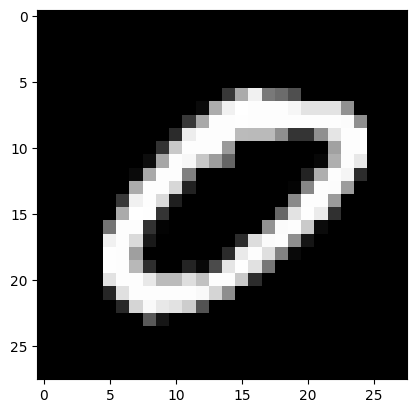

In [4]:
import matplotlib.pyplot as plt

# Choose a random image from the training set
image_index = np.random.randint(len(train_images))

# Display the image
plt.imshow(train_images[image_index], cmap='gray')
plt.show()

## Baseline Model

You will first build and train a Keras model. This will be the baseline where you will be comparing the mobile optimized versions later on. This will just be a shallow CNN with a softmax output to classify a given MNIST digit. You can review the `model_builder()` function in the utilities at the top of this notebook but we also printed the model summary below to show the architecture.

You will also save the weights so you can reinitialize the other models later the same way. This is not needed in real projects but for this demo notebook, it would be good to have the same initial state later so you can compare the effects of the optimizations.

In [7]:
# Create the baseline model
baseline_model = model_builder() # 初始化CNN模型

# Save the initial weights for use later
baseline_model.save_weights(FILE_WEIGHTS)

# Print the model summary
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

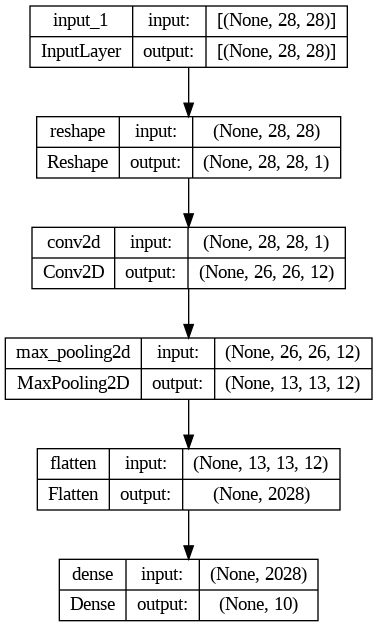

In [ ]:
tf.keras.utils.plot_model(baseline_model, to_file='model.png', show_shapes=True, show_layer_names=True)

You can then compile and train the model. In practice, it's best to shuffle the train set but for this demo, it is set to `False` for reproducibility of the results. One epoch below will reach around 91% accuracy.

In [8]:
# Setup the model for training
baseline_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
baseline_model.fit(train_images, train_labels, epochs=1, shuffle=False)

1875/1875 [==============================] - 21s 11ms/step - loss: 0.2834 - accuracy: 0.9209


Let's save the accuracy of the model against the test set so you can compare later.

In [9]:
# Get the baseline accuracy
_, ACCURACY['baseline Keras model'] = baseline_model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.1344 - accuracy: 0.9599


Next, you will save the Keras model as a file and record its size as well.

In [10]:
# Save the Keras model
# FILE_NON_QUANTIZED_H5 = 'non_quantized.h5'
# '.h5'是HDF5个市的文件扩展名，用于存储发型数据集的文件格式，常用于保存DL模型

# include_optimizer=False 表示在保存模型时不包括优化器的状态。
# 这通常用于减少保存文件的大小，因为优化器状态不是用于模型推理的必要信息
baseline_model.save(FILE_NON_QUANTIZED_H5, include_optimizer=False)

# Save and get the model size （以字节bit为单位）
MODEL_SIZE['baseline h5'] = os.path.getsize(FILE_NON_QUANTIZED_H5)

# Print records so far
print_metric(ACCURACY, "test accuracy")
print_metric(MODEL_SIZE, "model size in bytes")

test accuracy for baseline Keras model: 0.9599000215530396
model size in bytes for baseline h5: 98928


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Extra Note: warning中表示可以使用keras自带的模型格式：baseline_model.save('my_baseline_model.keras')

baseline_model.save('my_baseline_model.keras')

### Convert the model to TF Lite format

Next, you will convert the model to [Tensorflow Lite (TF Lite)](https://www.tensorflow.org/lite/guide) format. This is designed to make Tensorflow models more efficient and lightweight when running on mobile, embedded, and IOT devices.

You can convert a Keras model with TF Lite's [Converter](https://www.tensorflow.org/lite/convert/index) class and we've incorporated it in the short helper function below. Notice that there is a `quantize` flag which you can use to quantize the model.

In [12]:
def convert_tflite(model, filename, quantize=False):
  '''
  将Keras模型转换为TensorFlow Lite (TF Lite) 格式
  TF Lite 格式的模型更适用于在移动设备、嵌入式系统和物联网设备上运行，因为它们通常更高效、体积更小
  Converts the model to TF Lite format and writes to a file

  Args:
    model (Keras model) - model to convert to TF Lite
    filename (string) - string to use when saving the file
    quantize (bool) - flag to indicate quantization

  Returns:
    None
  '''

  # Initialize the converter
  # model: Keras模型对象，该例子中是 non_quantized.h5
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  # Set for quantization if flag is set to True
  # 当为True时，会应用量化优化，进一步减小模型大小并可能加快推理速度，但可能会牺牲一定的精度
  if quantize:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Convert the model
  tflite_model = converter.convert()

  # Save the model.
  with open(filename, 'wb') as f:
    f.write(tflite_model)

You will use the helper function to convert the Keras model then get its size and accuracy. Take note that this is *not yet* quantized.

In [13]:
# Convert baseline model 转换成 '.tflite'格式的模型数据

# FILE_NON_QUANTIZED_TFLITE = non_quantized.tflite
# TF Lite模型文件的名称
convert_tflite(baseline_model, FILE_NON_QUANTIZED_TFLITE)

You will notice that there is already a slight decrease in model size when converting to `.tflite` format.

可以发现 `.tflite`模型格式比`h5/keras`模型格式的存储的都小一些

keras的格式最大

In [14]:
MODEL_SIZE['non quantized tflite'] = os.path.getsize(FILE_NON_QUANTIZED_TFLITE)

keras_modelsize = os.path.getsize('/content/my_baseline_model.keras')

print('model size in bytes for baseline keras:', keras_modelsize)

print_metric(MODEL_SIZE, 'model size in bytes')

model size in bytes for baseline keras: 272595
model size in bytes for baseline h5: 98928
model size in bytes for non quantized tflite: 85096


The accuracy will also be nearly identical when converting between formats. You can setup a TF Lite model for input-output using its [Interpreter](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) class. This is shown in the `evaluate_tflite_model()` helper function provided in the `Utilities` section earlier.

*Note: If you see a `Runtime Error: There is at least 1 reference to internal data in the interpreter in the form of a numpy array or slice.` , please try re-running the cell.*

In [15]:
# 对转换成 `.tflite`格式的模型进行验证，使用测试集数据
ACCURACY['non quantized tflite'] = evaluate_tflite_model(FILE_NON_QUANTIZED_TFLITE, test_images, test_labels)

In [16]:
print_metric(ACCURACY, 'test accuracy')

test accuracy for baseline Keras model: 0.9599000215530396
test accuracy for non quantized tflite: 0.9599


### Post-Training Quantization

Now that you have the baseline metrics, you can now observe the effects of quantization. As mentioned in the lectures, this process involves converting floating point representations into integer to reduce model size and achieve faster computation.

As shown in the `convert_tflite()` helper function earlier, you can easily do [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with the TF Lite API. You just need to set the converter optimization and assign an [Optimize](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize) Enum.

You will set the `quantize` flag to do that and get the metrics again.

通过应用后训练量化来观察量化对模型大小的影响。

后训练量化是一种优化技术，它通过将模型中的浮点数表示转换为整数来减小模型大小并加快计算速度。

这在部署到资源受限的设备上时特别有用

In [17]:
# Convert and quantize the baseline model
convert_tflite(baseline_model, FILE_PT_QUANTIZED, quantize=True) # 设定True来启动量化

In [18]:
# Get the model size
MODEL_SIZE['post training quantized tflite'] = os.path.getsize(FILE_PT_QUANTIZED)

print_metric(MODEL_SIZE, 'model size')

model size for baseline h5: 98928
model size for non quantized tflite: 85096
model size for post training quantized tflite: 24336


You should see around a 4X reduction in model size in the quantized version. This comes from converting the 32 bit representations (float) into 8 bits (integer).



In [19]:
ACCURACY['post training quantized tflite'] = evaluate_tflite_model(FILE_PT_QUANTIZED, test_images, test_labels)

In [20]:
print_metric(ACCURACY, 'test accuracy')

test accuracy for baseline Keras model: 0.9599000215530396
test accuracy for non quantized tflite: 0.9599
test accuracy for post training quantized tflite: 0.9602


As mentioned in the lecture, you can expect the accuracy to not be the same when quantizing the model. Most of the time it will decrease but in some cases, it can even increase. Again, this can be attributed to the loss of precision when you remove the extra bits from the float data.

当对模型进行量化时，正如讲座中提到的，可以预期准确率会发生变化。大多数情况下，准确率可能会降低，但在某些情况下，准确率甚至可能提高。这种现象主要是由于从浮点数据中移除额外的位所导致的精度损失。

## Quantization Aware Training

When post-training quantization results in loss of accuracy that is unacceptable for your application, you can consider doing [quantization aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training) before quantizing the model. This simulates the loss of precision by inserting fake quant nodes in the model during training. That way, your model will learn to adapt with the loss of precision to get more accurate predictions.

The [Tensorflow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) provides a [quantize_model()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/quantization/keras/quantize_model) method to do this quickly and you will see that below. But first, let's install the toolkit into the notebook environment.

In [21]:
# Install the toolkit
!pip install tensorflow_model_optimization==0.7.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.8 MB/s eta 0:00:00


You will build the baseline model again but this time, you will pass it into the `quantize_model()` method to indicate quantization aware training.

Take note that in case you decide to pass in a model that is already trained, then make sure to recompile before you continue training.

In [22]:
import tensorflow_model_optimization as tfmot

# method to quantize a Keras model
quantize_model = tfmot.quantization.keras.quantize_model

# Define the model architecture.
model_to_quantize = model_builder()

# Reinitialize weights with saved file
model_to_quantize.load_weights(FILE_WEIGHTS)

# Quantize the model
q_aware_model = quantize_model(model_to_quantize)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_reshape_2 (QuantizeW  (None, 28, 28, 1)         1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_2 (QuantizeWr  (None, 26, 26, 12)        147       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_2 (Qua  (None, 13, 13, 12)        1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_flatten_2 (QuantizeW  (None, 2028)             

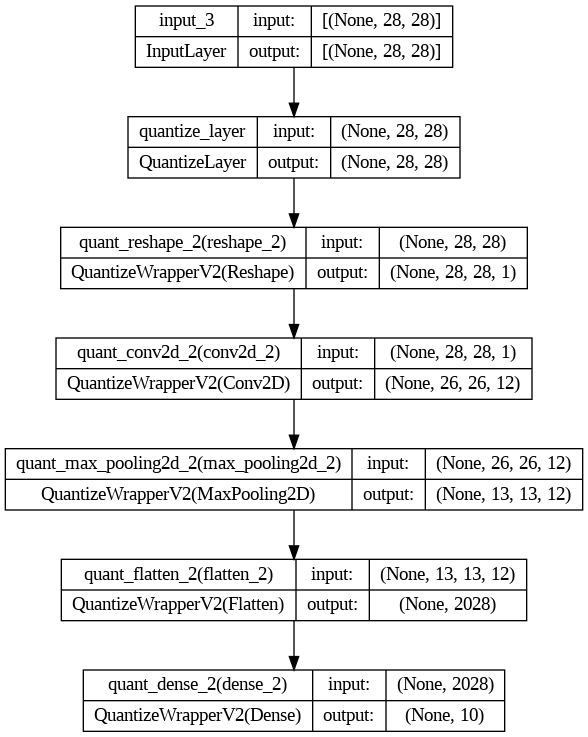

In [23]:
tf.keras.utils.plot_model(q_aware_model, to_file='model.png', show_shapes=True, show_layer_names=True)

You may have noticed a slight difference in the model summary above compared to the baseline model summary in the earlier sections. The total params count increased as expected because of the nodes added by the `quantize_model()` method.

With that, you can now train the model. You will notice that the accuracy is a bit lower because the model is simulating the loss of precision. The training will take a bit longer if you want to achieve the same training accuracy as the earlier run. For this exercise though, we will keep to 1 epoch.

在应用了`quantize_model()`方法后，您可能注意到模型摘要（summary）与之前基线模型的摘要有所不同，特别是总参数数量增加了。这是因为`quantize_model()`方法在模型中添加了额外的节点以模拟量化过程，从而导致参数数量的增加。

当训练量化感知（quantization-aware）模型时，由于模型正在模拟精度损失，您可能会发现准确率略有下降。这是因为量化过程本质上是一种优化技术，它通过减少数值的表示精度来减小模型大小和加速计算，但这可能会以牺牲一定的模型性能为代价。因此，在量化感知训练过程中，模型学习如何在降低精度的情况下保持尽可能高的准确率。

此外，要达到与之前运行相同的训练准确率，训练时间可能会稍长。这是因为模型需要额外的训练来适应由于量化而引入的约束。但是，在这个练习中，我们将训练周期限制为1个周期（epoch），这意味着模型只会通过整个训练数据集训练一次。这是一个权衡决策，旨在减少训练时间，尽管这可能导致模型准确率不是最优。

通过这种方式，即使在模拟量化损失的情况下，您仍然可以获得对量化模型性能的初步了解，并了解量化对模型训练和性能的影响。这对于准备将模型部署到资源受限的环境中非常有用，因为您可以在部署前评估量化对模型性能的可能影响。

In [24]:
# Train the model
q_aware_model.fit(train_images, train_labels, epochs=1, shuffle=False)

1875/1875 [==============================] - 24s 12ms/step - loss: 0.2837 - accuracy: 0.9210


You can then get the accuracy of the Keras model before and after quantizing the model. The accuracy is expected to be nearly identical because the model is trained to counter the effects of quantization.

使用test set的validation结果(Accuracy)和没用使用量化感知的模型相比非常近似

In [25]:
# Reinitialize the dictionary
ACCURACY = {}

# Get the accuracy of the quantization aware trained model (not yet quantized)
_, ACCURACY['quantization aware non-quantized'] = q_aware_model.evaluate(test_images, test_labels, verbose=0)
print_metric(ACCURACY, 'test accuracy')

test accuracy for quantization aware non-quantized: 0.9595000147819519


In [26]:
# Convert and quantize the model.
convert_tflite(q_aware_model, FILE_QAT_QUANTIZED, quantize=True)

# Get the accuracy of the quantized model
ACCURACY['quantization aware quantized'] = evaluate_tflite_model(FILE_QAT_QUANTIZED, test_images, test_labels)
print_metric(ACCURACY, 'test accuracy')

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


test accuracy for quantization aware non-quantized: 0.9595000147819519
test accuracy for quantization aware quantized: 0.9595


## Pruning

Let's now move on to another technique for reducing model size: [Pruning](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras). This process involves zeroing out insignificant (i.e. low magnitude) weights. The intuition is these weights do not contribute as much to making predictions so you can remove them and get the same result. Making the weights sparse helps in compressing the model more efficiently and you will see that in this section.

模型修剪(pruning)是另一种用于减小模型大小的技术。它通过将不重要（即幅值较低）的权重置零来实现。直觉上，这些权重对于做出预测的贡献不大，因此可以移除它们而不影响结果。使权重变得稀疏有助于更有效地压缩模型

The Tensorflow Model Optimization Toolkit again has a convenience method for this. The [prune_low_magnitude()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/prune_low_magnitude) method puts wrappers in a Keras model so it can be pruned during training. You will pass in the baseline model that you already trained earlier. You will notice that the model summary show increased params because of the wrapper layers added by the pruning method.

You can set how the pruning is done during training. Below, you will use [PolynomialDecay](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PolynomialDecay) to indicate how the sparsity ramps up with each step. Another option available in the library is [Constant Sparsity](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity).

In [28]:
# Get the pruning method 获取TensorFlow Model Optimization Toolkit提供的修剪方法
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
# 计算基于训练图像的数量、批处理大小和周期数，确定了修剪将持续的总训练步骤
# np.ceil()向上取整
# 计算每个训练周期中的批次数。例如，如果有9000张图像，批次大小是128，那么将得到大约70.3的结果
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define pruning schedule.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, # 修剪过程一开始模型的稀疏度为50%
                                                               final_sparsity=0.80,   # 修剪过程结束时，模型的稀疏度应达到80%
                                                               begin_step=0,          # 修剪将从训练开始时立即启动
                                                               end_step=end_step)     # 修剪将在训练的xxx多步骤后结束
}
# 通过这种方式，修剪计划确保了在整个训练过程中，
#         模型的稀疏度将从50%渐增至80%，最终导致一个更加稀疏（因而更容易压缩）的模型。
# 这对于减小模型的大小以及提高在资源受限环境中的推理速度非常有帮助

# Pass in the trained baseline model
model_for_pruning = prune_low_magnitude(baseline_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshap  (None, 28, 28, 1)         1         
 e_1 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d  (None, 26, 26, 12)        230       
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 13, 13, 12)        1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_flatte  (None, 2028)              1         
 n_1 (PruneLowMagnitude)                                         
                                                      

You can also peek at the weights of one of the layers in your model. After pruning, you will notice that many of these will be zeroed out.

In [29]:
# Preview model weights
model_for_pruning.weights[1]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[-0.77833855,  0.0494484 , -0.51352537,  0.28553024,
          -0.4151883 ,  0.1369017 ,  0.2723433 , -0.0820891 ,
          -0.5842059 ,  0.01799024,  0.30132008,  0.299218  ]],

        [[-0.09031381,  0.10255653, -0.27903464,  0.6107458 ,
          -0.72356445,  0.05320394, -0.0237042 ,  0.3031133 ,
          -0.5695683 ,  0.16578723,  0.13703705,  0.03355106]],

        [[ 0.4134407 ,  0.21310371, -0.1340362 ,  0.60323536,
          -0.5888208 ,  0.26087976,  0.04462536,  0.04763532,
          -0.4987794 , -0.0318762 ,  0.06509517, -0.07833558]]],


       [[[-0.7201865 ,  0.24422252, -0.16637067,  0.1592756 ,
          -0.56198144,  0.28176826,  0.18147463,  0.24063979,
           0.07149589,  0.18227851, -0.18309058,  0.06618655]],

        [[ 0.3758553 ,  0.06054633,  0.07053179,  0.08381667,
          -0.09624509,  0.13477276, -0.04409346,  0.32090694,
           0.08286845,  0.16872938,  0.3115

With that, you can now start re-training the model. Take note that the [UpdatePruningStep()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/UpdatePruningStep) callback is required.

In [30]:
# Callback to update pruning wrappers at each step
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

# Train and prune the model
model_for_pruning.fit(train_images, train_labels,
                  epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 23s 12ms/step - loss: 0.1410 - accuracy: 0.9647 - val_loss: 0.0896 - val_accuracy: 0.9758
Epoch 2/2
1688/1688 [==============================] - 20s 12ms/step - loss: 0.0993 - accuracy: 0.9717 - val_loss: 0.0782 - val_accuracy: 0.9800


Now see how the weights in the same layer looks like after pruning.

In [31]:
# Preview model weights
# 当baseline_model模型经过pruning过滤后，生成了model_for_pruning
# 再将model_for_pruning模型用于training，最后得到的模型权重就会因为第二步的修建策略而被置零
model_for_pruning.weights[1]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[-1.1899862 ,  0.        , -0.8125461 , -0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
          -0.9355    ,  0.        ,  0.7131221 ,  0.        ]],

        [[-0.        ,  0.        ,  0.        ,  1.0325801 ,
          -1.1680068 ,  0.        , -0.        ,  0.        ,
          -1.1142412 ,  0.        , -0.        ,  0.        ]],

        [[ 1.1002926 ,  0.        ,  0.        ,  1.0202308 ,
          -0.8625908 ,  0.        , -0.        ,  0.        ,
          -0.        ,  0.        , -0.        ,  0.        ]]],


       [[[-0.53248644,  0.        ,  0.        , -0.        ,
          -1.3567847 ,  0.864117  , -0.        ,  0.        ,
          -0.        ,  0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
          -0.        ,  0.        ,  0.7712

After pruning, you can remove the wrapper layers to have the same layers and params as the baseline model. You can do that with the [strip_pruning()](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/strip_pruning) method as shown below. You will do this so you can save the model and also export to TF Lite format just like in the previous sections.

In [33]:
# Remove pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2028)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

在模型修剪过程中添加的包装层（wrapper layers）主要用于在训练过程中实施修剪策略，即在训练的每一步中动态地将模型中的一些权重置零。这些包装层是为了在训练过程中实现和管理修剪而添加的，它们自身并不包含训练中学习到的参数，也不对模型的推理性能产生直接影响。

一旦训练完成，并且达到了所需的稀疏度，修剪过程实际上已经结束。此时，模型的权重已经被修剪，而包装层的作用——在训练期间管理权重的修剪——已经不再需要。因此，可以从模型中移除这些包装层，而不会改变模型的推理行为或推理性能。移除包装层后，模型将仅包含其原始的层和结构，但带有修剪后的权重。

移除包装层的主要原因和好处包括：

1. 简化模型结构：移除包装层后，模型将恢复到其原始的、更简洁的结构，这使得模型更容易理解和分析。
2. 减小模型大小：虽然包装层本身可能不包含大量的参数，但移除它们可以进一步减少模型的总体大小，尤其是当模型被保存和部署时。
3. 提高兼容性：在某些情况下，模型部署工具或环境可能不支持这些特定于修剪的包装层。移除包装层后，模型将更容易被转换和部署到各种平台和设备上，比如使用TensorFlow Lite进行边缘设备部署。
4. 维持推理性能：移除包装层后，模型在推理时的计算量会减少，有助于维持或提高模型在实际应用中的推理速度。

因此，一旦修剪过程完成，移除包装层是一种常见且有益的做法，可以让模型更加精简和高效，同时保留修剪带来的所有好处。


You will see the same model weights but the index is different because the wrappers were removed.

In [34]:
# Preview model weights (index 1 earlier is now 0 because pruning wrappers were removed)
model_for_export.weights[0]

<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[-1.1899862 ,  0.        , -0.8125461 , -0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
          -0.9355    ,  0.        ,  0.7131221 ,  0.        ]],

        [[-0.        ,  0.        ,  0.        ,  1.0325801 ,
          -1.1680068 ,  0.        , -0.        ,  0.        ,
          -1.1142412 ,  0.        , -0.        ,  0.        ]],

        [[ 1.1002926 ,  0.        ,  0.        ,  1.0202308 ,
          -0.8625908 ,  0.        , -0.        ,  0.        ,
          -0.        ,  0.        , -0.        ,  0.        ]]],


       [[[-0.53248644,  0.        ,  0.        , -0.        ,
          -1.3567847 ,  0.864117  , -0.        ,  0.        ,
          -0.        ,  0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
          -0.        ,  0.        ,  0.7712

You will notice below that the pruned model will have the same file size as the baseline_model when saved as H5. This is to be expected. The improvement will be noticeable when you compress the model as will be shown in the cell after this.

In [35]:
# Save Keras model
model_for_export.save(FILE_PRUNED_MODEL_H5, include_optimizer=False)

# Get uncompressed model size of baseline and pruned models
MODEL_SIZE = {}
MODEL_SIZE['baseline h5'] = os.path.getsize(FILE_NON_QUANTIZED_H5)
MODEL_SIZE['pruned non quantized h5'] = os.path.getsize(FILE_PRUNED_MODEL_H5)

print_metric(MODEL_SIZE, 'model_size in bytes')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model_size in bytes for baseline h5: 98928
model_size in bytes for pruned non quantized h5: 98928


You will use the `get_gzipped_model_size()` helper function in the `Utilities` to compress the models and get its resulting file size. You will notice that the pruned model is about 3 times smaller. This is because of the sparse weights generated by the pruning process. The zeros can be compressed much more efficiently than the low magnitude weights before pruning.

In [36]:
# Get compressed size of baseline and pruned models
MODEL_SIZE = {}
MODEL_SIZE['baseline h5'] = get_gzipped_model_size(FILE_NON_QUANTIZED_H5)
MODEL_SIZE['pruned non quantized h5'] = get_gzipped_model_size(FILE_PRUNED_MODEL_H5)

print_metric(MODEL_SIZE, "gzipped model size in bytes")

gzipped model size in bytes for baseline h5: 78025
gzipped model size in bytes for pruned non quantized h5: 25963


You can make the model even more lightweight by quantizing the pruned model. This achieves around 10X reduction in compressed model size as compared to the baseline.

通过对已经修剪的模型进行量化，使模型更加轻量化。量化是一种减少模型大小的技术，它通过将模型中的浮点数值转换为整数来实现。当您将修剪和量化结合使用时，可以显著减小模型的大小，这在压缩模型大小方面相对于基线模型可以达到大约10倍的减少。

In [37]:
# Convert and quantize the pruned model.
pruned_quantized_tflite = convert_tflite(model_for_export, FILE_PRUNED_QUANTIZED_TFLITE, quantize=True)

# Compress and get the model size
MODEL_SIZE['pruned quantized tflite'] = get_gzipped_model_size(FILE_PRUNED_QUANTIZED_TFLITE)
print_metric(MODEL_SIZE, "gzipped model size in bytes")

gzipped model size in bytes for baseline h5: 78025
gzipped model size in bytes for pruned non quantized h5: 25963
gzipped model size in bytes for pruned quantized tflite: 8389


通过这些结果可以看到，修剪和量化结合使用可以显著减小模型的大小，使其更适合部署到资源受限的环境中。在这个例子中，修剪并量化的模型相比于基线模型在压缩后的大小上实现了大约10倍的减少。这种体积的减少不仅有助于节省存储空间，还可以减少模型部署和更新时所需的带宽，提高在边缘设备上的推理速度

As expected, the TF Lite model's accuracy will also be close to the Keras model.

In [38]:
# Get accuracy of pruned Keras and TF Lite models
ACCURACY = {}

_, ACCURACY['pruned model h5'] = model_for_pruning.evaluate(test_images, test_labels)
ACCURACY['pruned and quantized tflite'] = evaluate_tflite_model(FILE_PRUNED_QUANTIZED_TFLITE, test_images, test_labels)

print_metric(ACCURACY, 'accuracy')

313/313 [==============================] - 1s 5ms/step - loss: 0.0876 - accuracy: 0.9736
accuracy for pruned model h5: 0.9735999703407288
accuracy for pruned and quantized tflite: 0.9738


## Wrap Up

In this notebook, you practiced several techniques in optimizing your models for mobile and embedded applications. You used quantization to reduce floating point representations into integer, then used pruning to make the weights sparse for efficient model compression. These make your models lightweight for efficient transport and storage without sacrificing model accuracy. Try this in your own models and see what performance you get. For more information, here are a few other resources:

* [Post Training Quantization Guide](https://www.tensorflow.org/lite/performance/post_training_quantization)
* [Quantization Aware Training Comprehensive Guide](https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide)
* [Pruning Comprehensive Guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)

**Congratulations and enjoy the rest of the course!**